In [3]:
# GAN corrigido com saída linear no Generator + Reescalonamento para RSSI

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Sequential, Input, Model
import matplotlib.pyplot as plt


In [2]:

# ================================
# 1. Dados reais de entrada (X_real)
# ================================
df_real = pd.read_csv("/home/darkcover/Documentos/Gan/Data/df_simulated.csv")
X_real = df_real.iloc[:, :10].values.astype(np.float32)

n_features = X_real.shape[1]  # 10 WAPs
latent_dim = n_features       # 10


In [5]:

# ================================
# 2. Construir o Generator (1 camada oculta de 10 neurônios, saída linear)
# ================================
def build_generator():
    inp = Input(shape=(latent_dim,))
    x = layers.Dense(10, activation='relu')(inp)
    out = layers.Dense(n_features, activation='linear')(x)  # Saída linear
    return Model(inp, out, name="Generator")

In [7]:

# ================================
# 3. Construir o Discriminator (1 camada oculta de 10 neurônios, saída sigmoid)
# ================================
def build_discriminator():
    inp = Input(shape=(n_features,))
    x = layers.Dense(10, activation='relu')(inp)
    out = layers.Dense(1, activation='sigmoid')(x)  # Saída sigmoid
    return Model(inp, out, name="Discriminator")


In [8]:

# ================================
# 4. Montar e Compilar o GAN
#    - Discriminator: loss='binary_crossentropy', optimizer=Adam(0.01)
#    - Generator: loss='binary_crossentropy', optimizer=Adam(0.01)
#    - GAN: loss='binary_crossentropy', optimizer=Adam(0.01)
# ================================
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(
            optimizer=tf.keras.optimizers.Adam(0.01),
            loss='binary_crossentropy')

discriminator.trainable = False # Durante o treino do Gan, mantém D fixo

# Montar o GAN
gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output, name="GAN")
# Compilar o GAN
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01))


In [9]:
# ================================
# 5. Loop de Treinamento GAN
# ================================
epochs = 200
batch_size = 100
half_batch = batch_size // 2
d_losses, g_losses = [], []

for epoch in range(1,epochs+1):
    # 5.1 Treina D com amostras reais
    idx = np.random.randint(0, X_real.shape[0], half_batch)
    real_samples = X_real[idx]
    real_labels = np.ones((half_batch, 1))
    d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
    
    # 5.2 Treina D com amostras falsas
    noise = np.random.uniform(-1, 1, (half_batch, latent_dim))
    fake_samples = generator.predict(noise, verbose=0)
    fake_labels = np.zeros((half_batch, 1))
    d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    
    # 5.3 Treina G
    noise = np.random.uniform(-1, 1, (batch_size, latent_dim))
    valid_y = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise, valid_y)

    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{epochs} | D_loss: {d_loss:.4f} | G_loss: {g_loss:.4f}")


/home/darkcover/.cache/pypoetry/virtualenvs/gan-oPyfrVEv-py3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 20/200 | D_loss: 0.4977 | G_loss: 0.4974
Epoch 40/200 | D_loss: 0.8355 | G_loss: 0.3240
Epoch 60/200 | D_loss: 1.2146 | G_loss: 0.2289
Epoch 80/200 | D_loss: 1.5501 | G_loss: 0.1742
Epoch 100/200 | D_loss: 1.8200 | G_loss: 0.1404
Epoch 120/200 | D_loss: 2.0346 | G_loss: 0.1175
Epoch 140/200 | D_loss: 2.2109 | G_loss: 0.1010
Epoch 160/200 | D_loss: 2.3585 | G_loss: 0.0886
Epoch 180/200 | D_loss: 2.4837 | G_loss: 0.0789
Epoch 200/200 | D_loss: 2.5940 | G_loss: 0.0711


In [11]:
# Salvar Generator e Discriminator
generator.save("/home/darkcover/Documentos/Gan/Models/Modelsgenerator.keras")
discriminator.save("/home/darkcover/Documentos/Gan/Models/Modelsdiscriminator.keras")
print("✅ Generator e Discriminator salvos em models/")


✅ Generator e Discriminator salvos em models/


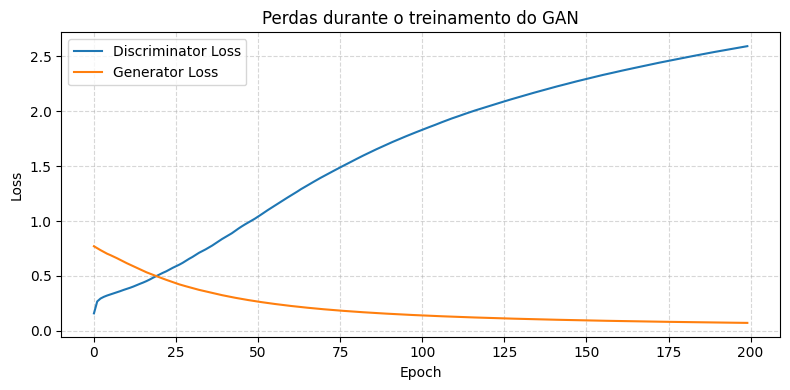

In [13]:

# ================================
# 6. Plotar perdas
# ================================
plt.figure(figsize=(8, 4))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Perdas durante o treinamento do GAN")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [14]:
# 7. Geração de 10 blocos de 4.000 - 40.000 amostras sintéticas
mf_blocks = 10
samples_per_block = 4000
generated_blocks = []

for _ in range(mf_blocks):
    noise_block = np.random.uniform(-1, 1, size=(samples_per_block, latent_dim))
    raw_block = generator.predict(noise_block, verbose=0)
    generated_blocks.append(raw_block)
    print(f"Bloco de {samples_per_block} amostras gerado com sucesso")

# Concatenar os blocos gerados
generated_raw = np.vstack(generated_blocks)
# Reescalonamento para RSSI
min_raw, max_raw = generated_raw.min(), generated_raw.max()
scaled = (generated_raw - min_raw) / (max_raw - min_raw)
rssi = scaled * 70 - 110

columns = [f"WAP{str(i+1).zfill(3)}" for i in range(n_features)]
df_generated = pd.DataFrame(np.round(rssi).astype(int), columns=columns)
df_generated = df_generated.clip(lower=-110, upper=-40)

Bloco de 4000 amostras gerado com sucesso
Bloco de 4000 amostras gerado com sucesso
Bloco de 4000 amostras gerado com sucesso
Bloco de 4000 amostras gerado com sucesso
Bloco de 4000 amostras gerado com sucesso
Bloco de 4000 amostras gerado com sucesso
Bloco de 4000 amostras gerado com sucesso
Bloco de 4000 amostras gerado com sucesso
Bloco de 4000 amostras gerado com sucesso
Bloco de 4000 amostras gerado com sucesso


In [15]:
df_generated.describe()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.0000,40000.000000,40000.000000,40000.000000,40000.000000
mean,-72.304300,-66.314075,-84.710575,-55.601425,-91.486500,-56.7046,-86.928525,-59.681625,-80.286775,-92.850525
std,2.072235,2.581579,3.678491,3.424910,3.693394,3.7596,4.390803,2.787877,3.347576,3.430230
min,-80.000000,-74.000000,-100.000000,-64.000000,-107.000000,-66.0000,-107.000000,-70.000000,-95.000000,-110.000000
25%,-74.000000,-68.000000,-87.000000,-58.000000,-94.000000,-60.0000,-90.000000,-62.000000,-82.000000,-95.000000
50%,-72.000000,-66.000000,-84.000000,-56.000000,-91.000000,-57.0000,-87.000000,-60.000000,-80.000000,-92.000000
75%,-71.000000,-65.000000,-82.000000,-53.000000,-89.000000,-54.0000,-84.000000,-58.000000,-78.000000,-90.000000
max,-65.000000,-57.000000,-76.000000,-40.000000,-80.000000,-42.0000,-75.000000,-49.000000,-73.000000,-85.000000


In [16]:
df_generated.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010
0,-73,-62,-91,-54,-90,-60,-89,-62,-83,-90
1,-69,-69,-80,-55,-93,-48,-88,-55,-79,-98
2,-71,-63,-90,-55,-88,-59,-90,-59,-79,-88
3,-70,-66,-81,-58,-86,-53,-84,-60,-81,-91
4,-70,-70,-78,-60,-90,-57,-83,-59,-78,-92


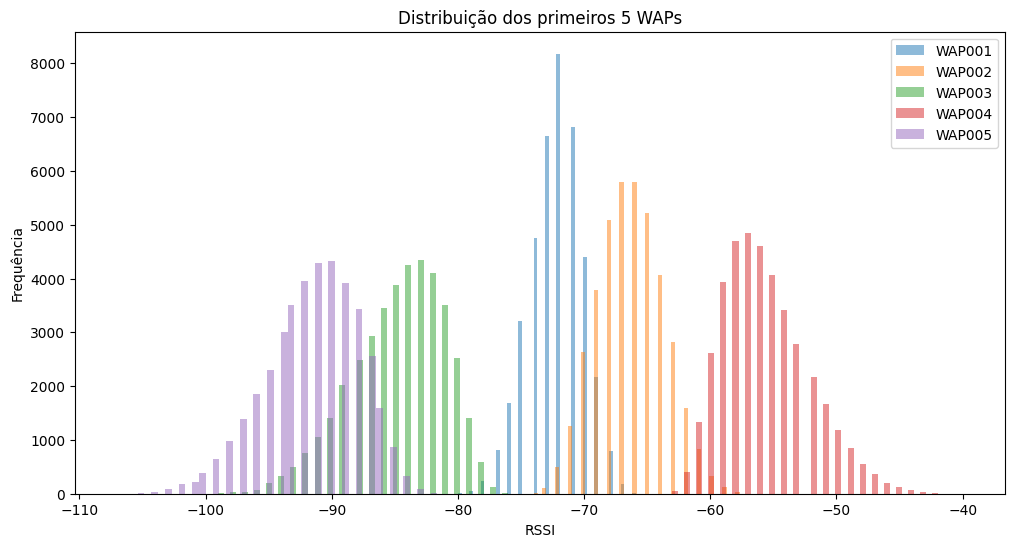

In [17]:
# Exemplo de histograma para os primeiros 5 WAPs
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.hist(df_generated.iloc[:, i], bins=50, alpha=0.5, label=columns[i])
plt.title("Distribuição dos primeiros 5 WAPs")
plt.xlabel("RSSI")
plt.ylabel("Frequência")
plt.legend()
plt.tight_layout
plt.show()

In [18]:

df_generated.to_csv("/home/darkcover/Documentos/Gan/Data/df_generated.csv", index=False)
print("df_generated.csv salvo com sucesso com RSSI reescalonado")


df_generated.csv salvo com sucesso com RSSI reescalonado
